# BME1063 HW1 Visualization and Analyzation

## package information

* python version 3.7.6
* numpy version 1.18.1
* pandas version 1.0.3
* matplotlib version 3.1.3


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [48]:
figure_path='../FinalReport/images'

## Runtime vidualization

* Runtime information path: `FinalReport/time_summary`

In [11]:
info_path = '../FinalReport/time_summary'

# read data from time summary
bwa_time = []
bowtie_time = []

with open(os.path.join(info_path, 'bwa_time_summary.txt'), 'r') as f:
    line = f.readline()
    # loop over the file and find 3 line start with 'user'
    while line != '':
        if line.split()[0] == 'user':
            time = line.split()[1]
            bwa_time.append(float(time.split('m')[1][:-1]) + float(time.split('m')[0])*60)
        line = f.readline()

with open(os.path.join(info_path, 'bowtie2_time_summary.txt'), 'r') as f:
    line = f.readline()
    # loop over the file and find 3 line start with 'user'
    while line != '':
        if line.split()[0] == 'user':
            time = line.split()[1]
            bowtie_time.append(float(time.split('m')[1][:-1]) + float(time.split('m')[0])*60)
        line = f.readline()

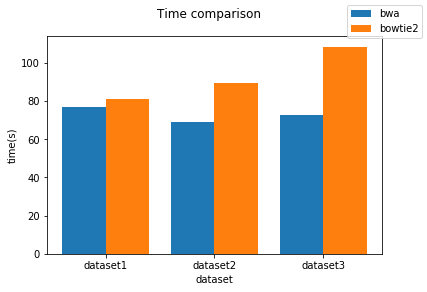

In [49]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(range(3), bwa_time, width=0.4, label='bwa')
ax.bar([i + 0.4 for i in range(3)], bowtie_time, width=0.4, label='bowtie2')
# set ticks, tick labels and labels
ax.set(
    xticks=[i+0.2 for i in range(3)], 
    xticklabels=['dataset1', 'dataset2', 'dataset3'],
    xlabel='dataset', 
    ylabel='time(s)', 
)
fig.legend()
fig.suptitle('Time comparison')
fig.savefig(os.path.join(figure_path, 'time_comparison.png'))
fig